<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/410_reglin_3.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>

(reglin_pymc_notebook)=
# Regressione lineare con PyMC

In questo capitolo ci concentreremo sull'analisi bayesiana del modello di regressione lineare. In generale, i frequentisti esprimono il modello di regressione lineare come:

$$
Y = \alpha + \beta X + \varepsilon
$$

dove

- $Y$ rappresenta l'output da prevedere (o variabile dipendente),
- $X$ è il predittore (o variabile indipendente),
- $\alpha$, $\beta$ sono i coefficienti (o parametri) del modello da stimare,
- $\varepsilon$ è il termine di errore che si assume distribuito normalmente.

Per trovare le stime dei parametri $\alpha$ e $\beta$, i frequentisti utilizzano il metodo dei minimi quadrati ordinari (OLS) o la massima verosimiglianza, cercando di minimizzare una determinata quantità (come ad esempio la somma dei residui quadratici).

I bayesiani esprimono invece il modello di regressione lineare in termini di distribuzioni di probabilità. Il modello può essere riformulato come segue:

$$
\begin{align}
Y   & \sim \mathcal{N}(\mu, \sigma)\\\notag
\mu & = \alpha + \beta X
\end{align}
$$

dove

- $\alpha$ rappresenta l'intercetta,
- $\beta$ rappresenta la pendenza,
- $\sigma$ rappresenta l'errore di osservazione.

Si noti che, in questa rappresentazione del modello di regressione, il valore $\mu$ non è costante, ma dipende da $X$. La relazione tra $\mu$ (il valore atteso della $Y$) è determinstica: $\mu$ è espresso come una funzione lineare di $X$.

Il modello di regressione lineare può quindi essere esposto in modo bayesiano, dicendo che $Y$ segue una distribuzione normale con media data dal predittore lineare $\alpha + \beta X$ e varianza $\sigma^2$. Questo permette di utilizzare distribuzioni a priori sui parametri del modello, come ad esempio una distribuzione a priori che favorisce valori bassi per $\sigma$. Inoltre, la stima bayesiana produce una distribuzione a posteriori per i parametri, che consente di quantificare l'incertezza sulla stima del parametro $\beta$ in modo più preciso rispetto all'approccio frequentista.

Per costruire il modello lineare con PyMC, iniziamo importando i moduli necessari.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pymc as pm
import warnings

from pymc import HalfCauchy, Model, Normal, sample

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

print(f"Running on PyMC v{pm.__version__}")


Running on PyMC v5.5.0


In [2]:
# Initialize random number generator
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

sns.set_theme(palette="colorblind")

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%config InlineBackend.figure_format = "svg"


## Simulazione

In questo esempio, simuleremo dei dati per testare un modello di regressione lineare bayesiano. Il nostro modello suppone che la variabile dipendente $Y$ sia distribuita normalmente con media data dal predittore lineare $\alpha+\beta X$ e una specifica varianza $\sigma^2$. Utilizzeremo il modulo `random` di `NumPy` per generare dei dati artificiali e, successivamente, utilizzeremo PyMC per stimare i parametri del modello attraverso un'analisi bayesiana. Confrontando i risultati ottenuti con i parametri "veri" utilizzati per generare i dati, potremo valutare quanto il modello sia in grado di ricostruire il processo generativo sottostante.

In [3]:
# True parameter values
alpha = 1 
beta = 1.5
sigma = 2.0

# Size of dataset
size = 100

# Predictor variable
X = np.random.randn(size)

# Simulate outcome variable
Y = alpha + beta * X + rng.normal(size=size) * sigma

df = pd.DataFrame({"x": X, "y": Y})
df.head()


,x,y
0,-0.302860,1.155144
1,-0.860673,-2.370977
2,-0.373392,1.940814
3,0.104446,3.037798
4,0.668760,-1.898930


Visualizziamo i dati simulati mediante un diagramma a dispersione.

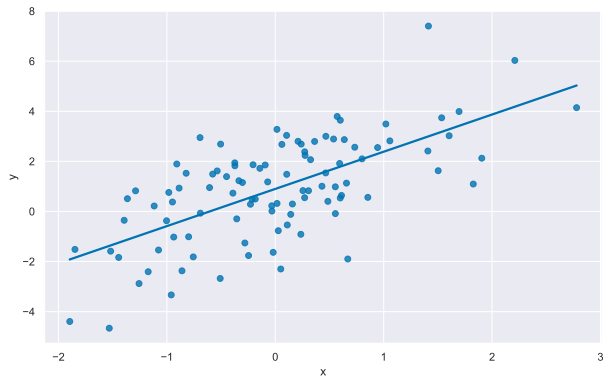

In [4]:
sns.regplot(x="x", y="y", data=df, ci=None);

## Distribuzioni a priori

Poiché stiamo costruendo un modello di regressione lineare bayesiana, dobbiamo specificare le distribuzioni a priori per le variabili del modello che non conosciamo. In questo caso, scegliamo di assegnare distribuzioni normali a media zero e varianza di 2 ai coefficienti di regressione $\alpha$ e $\beta$, che rappresentano le nostre conoscenze iniziali circa i possibili valori dei parametri. Questa scelta riflette un atteggiamento neutrale o debolmente informativo rispetto ai parametri, fornendo solo un'informazione limitata sulla loro possibile distribuzione.

Per la varianza dell'errore di osservazione $\sigma^2$, scegliamo una distribuzione di Cauchy troncata, limitata a zero, di parametro 5. Questa scelta riflette l'idea che la varianza sia una quantità positiva, il che impedisce alla distribuzione di attribuire probabilità a valori negativi. 

$$
\begin{align}
\alpha &\sim \mathcal{N}(0, 2)\notag\\
\beta &\sim \mathcal{N}(0, 2)\notag\\
\sigma &\sim \mid\text{Cauchy}(5) \mid\notag
\end{align}
$$


## Specificazione del modello

Definiamo ora il modello di regressione lineare bayesiano utilizzando PyMC. Successivamente, eseguiamo l'analisi bayesiana per ottenere la distribuzione a posteriori dei parametri.

In [5]:
with Model() as model:  # model specifications in PyMC are wrapped in a with-statement
    # Define priors
    sigma = HalfCauchy("sigma", beta=5)
    alpha = Normal("alpha", 0, sigma=2)
    beta = Normal("beta", 0, sigma=2)

    # Define likelihood
    likelihood = Normal("y", mu=alpha + beta * df["x"], sigma=sigma, observed=df["y"])

    # draw 3000 posterior samples using NUTS sampling
    idata = sample(3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, beta]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 32 seconds.


La funzione `sample` utilizza l'algoritmo NUTS (di default) per eseguire il campionamento della distribuzione a posteriori dei parametri del modello. Viene specificato un numero di iterazioni e `sample` restituisce un oggetto `InferenceData` che contiene i campioni raccolti dalle catene parallele generate dall'algoritmo di campionamento, insieme ad altri attributi. Si noti che il numero di catene parallele generate dipende dal numero di core di calcolo disponibili sulla macchina.

Diamo una rapida occhiata al modello che abbiamo appena stimato utilizzando il metodo `model_to_graphviz`.

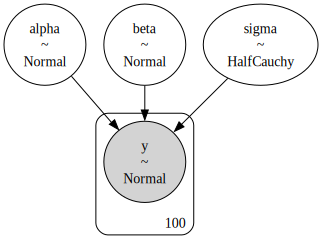

In [6]:
pm.model_to_graphviz(model)


Riscrivo: Nel processo di costruzione del modello, abbiamo stabilito alcune ipotesi che meritano di essere evidenziate. La prima ipotesi afferma che, condizionatamente a $X$, i dati $y$ sono indipendenti; la seconda afferma che il valore atteso di $Y$ è una funzione lineare di $X$; la terza ipotesi stabilisce che, condizionatamente a $X_i$, la variabile $Y$ si distribuisce normalmente attorno al suo valore atteso con una deviazione standard $\sigma$, la quale risulta essere costante per $i \in 1, ..., n$. Queste tre ipotesi costituiscono la base della regressione normale bayesiana.

## Interpretare i risultati della regressione bayesiana

La collezione di campioni generati dalla distribuzione a posteriori costituisce una "traccia", che viene restituita dalla funzione `pm.sample`. Esaminiamo più da vicino questa traccia:

In [7]:
idata


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

Si noti che ci sono 4 catene, ciascuna formata da 2000 elementi, per ciascuno dei tre parametri ($\alpha$, $\beta$, $\sigma$)

L'oggetto `InferenceData` restituito dal metodo `pm.sample` contiene vari attributi che possono essere esaminati come un `dict` di `numpy.arrays`. Ad esempio, per vedere i primi 5 valori della variabile `alpha` in ogni catena, è possibile utilizzare il seguente codice:

In [8]:
idata.posterior["alpha"].sel(draw=slice(0, 4))


<xarray.DataArray 'alpha' (chain: 4, draw: 5)>
array([[0.83710116, 0.68769145, 0.96233134, 0.93554155, 0.95052538],
       [1.0511116 , 0.71417109, 0.79055584, 0.91594303, 0.81904656],
       [0.84204886, 0.90323421, 0.94599501, 0.89124812, 0.96077141],
       [0.96437709, 0.99933731, 0.82748668, 0.84296158, 0.91280582]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4

Per analizzare la distribuzione a posteriori in modo più semplice, possiamo utilizzare le funzioni del modulo `Arviz`. In particolare, possiamo creare un trace plot utilizzando la funzione `plot_trace`. Il trace plot è un grafico che rappresenta l'andamento della catena di Markov per ciascun parametro e per ciascuna catena parallela. È uno strumento utile per valutare la convergenza della catena al valore stazionario e per verificare l'indipendenza delle catene tra loro. In particolare, il plot ci permette di valutare se la catena esplora adeguatamente lo spazio dei parametri e se raggiunge un equilibrio tra la ricerca di nuove regioni e l'esplorazione delle regioni già visitate. Inoltre, il plot ci consente di valutare la presenza di autocorrelazione tra le iterazioni della catena, che può indicare una convergenza lenta o una convergenza a un valore sub-ottimale.

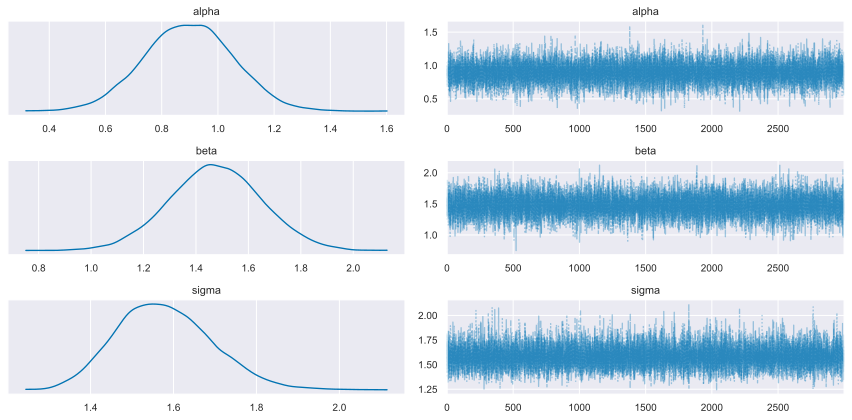

In [9]:
var_names = ["alpha", "beta", "sigma"]
az.plot_trace(idata, var_names=var_names, combined=True,)
plt.tight_layout()


La funzione `summary` ci fornisce un riepilogo delle stime dei parametri, compresi la media, la deviazione standard, la mediana, i valori minimi e massimi e altri valori percentili della distribuzione a posteriori. Questi risultati possono essere utilizzati per fare inferenza sui parametri e per confrontarli con i loro valori "veri" utilizzati per generare i dati.

In [10]:
az.summary(idata, kind="stats", round_to=2)

,mean,sd,hdi_3%,hdi_97%
alpha,0.89,0.16,0.61,1.20
beta,1.47,0.18,1.13,1.79
sigma,1.58,0.12,1.37,1.79


Il modello è stato in grado di fornire stime dei parametri che si avvicinano molto ai veri valori dei parametri del meccanismo di generazione dei dati utilizzati. Nell'inferenza bayesiana, le stime dei parametri sono facilmente interpretabili. Ad esempio, per il parametro $\beta$, la media della distribuzione a posteriori è 1.64, con una deviazione standard di 0.21 e un intervallo di credibilità del 94% che va da 1.24 a 2.03. L'HDI (highest density interval) rappresenta l'intervallo di densità più alta della distribuzione a posteriori e può essere personalizzato tramite l'argomento `hdi_prob=`.

Con buona confidenza possiamo dunque affermare che la stima di $\beta$ è circa uguale a 1.64. Il parametro usato per simulare i dati è 1.5.

## Distribuzione predittiva a posteriori

Una volta stimata la distribuzione a posteriori, possiamo utilizzarla per generare la distribuzione predittiva a posteriori. Questa distribuzione rappresenta le previsioni del modello che incorporano l'incertezza sui parametri. Per generare la distribuzione predittiva a posteriori, vengono generati $M$ campioni $\{x, y\}$, dove la variabile $x$ è uguale a quella del campione osservato. In ciascun campione, ogni valore $y_i$ per $i=1,\dots,n$ viene generato casualmente dalla distribuzione $\mathcal{N}(\mu = \alpha + \beta \cdot x_i, \sigma)$, dove i valori dei parametri $\alpha$, $\beta$, e $\sigma$ sono campionati dalle rispettive distribuzioni a posteriori. 

In [11]:
with model:
    pm.sample_posterior_predictive(
        idata, extend_inferencedata=True, random_seed=rng);

Sampling: [y]


Possiamo ora usare la funzione `az.plot_ppc()` per per il posterior predictive check.

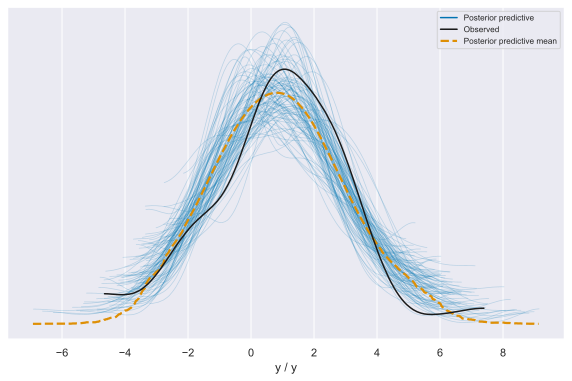

In [12]:
_ = az.plot_ppc(idata, num_pp_samples=100)
plt.show()

La distribuzione predittiva a posteriori può essere utilizzata per valutare la bontà del modello, come mostrato dal grafico prodotto da `az.plot_ppc()`. Le linee blu rappresentano le stime della distribuzione predittiva a posteriori e la linea nera rappresenta i dati osservati. È possibile notare che le previsioni a posteriori sono in linea con i dati osservati in tutta la gamma dei valori della variabile dipendente, indicando che il modello è in grado di fornire previsioni accurate.

**Esercizio.** Per i dati dell'esercizio descritto nel capitolo precedente, si proceda alla stima dei coefficienti del modello di regressione usando PyMC.  Si interpretino gli intervalli di credibilità al 94% per i due parametri. 

Si trovi la distribuzione predittiva a priori. Si interpreti.

Si trovi la distribuzione predittiva a posteriori. Si interpreti.

## Watermark

In [34]:
%load_ext watermark
%watermark -n -u -v -iv 

Last updated: Sat May 06 2023

Python implementation: CPython
Python version       : 3.11.3
IPython version      : 8.13.2

pandas    : 1.5.3
bambi     : 0.10.0
matplotlib: 3.7.1
seaborn   : 0.12.2
arviz     : 0.15.1
numpy     : 1.23.5
pymc      : 5.3.0

